# Basic Image Processing

**Suhas Somnath**<br>
National Center for Computational Sciences<br>
Oak Ridge National Laboratory

## Popular packages:
* [scikit-image](https://scikit-image.org/) a.k.a ``skimage`` - comes with Anaconda
* [Open CV for python](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_tutorials.html) a.k.a ``cv2`` - requires Conda installation

### Load necessary packages:

In [264]:
# Numeric operations
import numpy as np
# Visualization / Plotting
from matplotlib import pyplot as plt
# Scientific image processing library:
import skimage
from skimage import io
from skimage import filters
from skimage.morphology import disk
from skimage.feature import blob_log
from skimage import data
from skimage import exposure

# Ensure that images are rendered in this notebook:
%matplotlib inline

## Reading images
The most popular method to read image in python is through the ``scikit-image`` package that is also refered to as ``skimage`` using the ``skimage.io.imread()`` function

In [86]:
# Reading the image here:
stem_image = io.imread('LLTO_800.tif')

``skimage.img_as_float`` is a very handy function that is often used to normalize the data to ``[0, 1]`` from the original datatype

In [88]:
print('Before normalization: Min: {}, max: {}'.format(stem_image.min(), stem_image.max()))

# Normalizing here:
stem_image = skimage.img_as_float(stem_image)

print('After normalization: Min: {}, max: {}'.format(stem_image.min(), stem_image.max()))

Before normalization: Min: 2010, max: 59821
After normalization: Min: 0.030670634012359806, max: 0.9128099488822766


## Images are just matrices of numbers:

In [89]:
print('Image read as: {}'.format(type(stem_image)))
print('Image of shape: {} and precision: {}'.format(stem_image.shape, stem_image.dtype))

Image read as: <class 'numpy.ndarray'>
Image of shape: (512, 512) and precision: float64


In other words, the image has 512 rows and 512 columns.

Let's take a look at the contents of a single pixel:

In [90]:
stem_image[5, 4]

0.25439841306172273

## Visualizing images:
We will be using matplotlib for simplicity

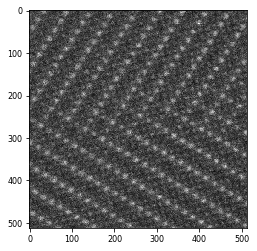

In [91]:
fig, axis = plt.subplots()
axis.imshow(stem_image, cmap='gray');

## Simple manipulations of images

Since images are just arrays of numbers, we can manipulat them easily just as we would any array:

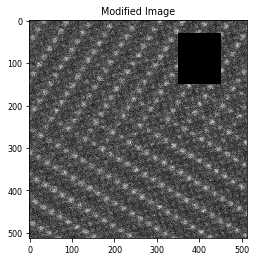

In [92]:
modified_image = stem_image.copy()

# Let's set a rectangle within the image to some new value:
modified_image[30:150, 350:450] = 0

# Visualize the modified image
fig, axis = plt.subplots()
axis.imshow(modified_image, cmap='gray')
axis.set_title('Modified Image');

Black and white images have a single **channel** of information while color images have three (red, green, blue) channels of information.

Thus a ``512``x``512`` pixel color image would be represented as a ``(512, 512, 3)`` array

Image shape: (300, 451, 3)


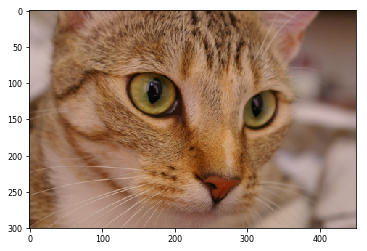

In [93]:


# Loading the built-in example dataset from scikit image:
cat = data.chelsea()

print("Image shape:", cat.shape)

fig, axis = plt.subplots()
axis.imshow(cat);

## Shapes of images when loaded into Python:

Adapted from [Stefan Van der Walt's tutorial](https://github.com/stefanv/imagexd_scientific_python/blob/master/images_are_arrays.ipynb)

|Image type|Coordinates|
|:---|:---|
|2D grayscale|(row, column)|
|2D multichannel|(row, column, channel)|
|3D grayscale|(plane, row, column)|
|3D multichannel|(plane, row, column, channel)|

## Histogram of image

Text(0.5,0,'Pixel intensity')

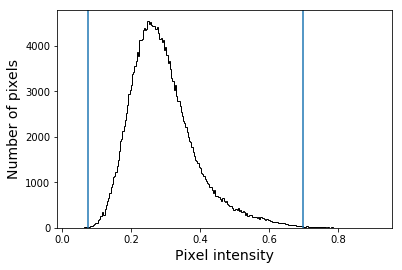

In [105]:
fig, axis = plt.subplots()
axis.hist(stem_image.ravel(), bins=256, histtype='step', color='black');
axis.axvline(x=0.075)
axis.axvline(x=0.7)
axis.set_ylabel('Number of pixels', fontsize=14)
axis.set_xlabel('Pixel intensity', fontsize=14)

## Contrast Adjustment

### Manual adjustment

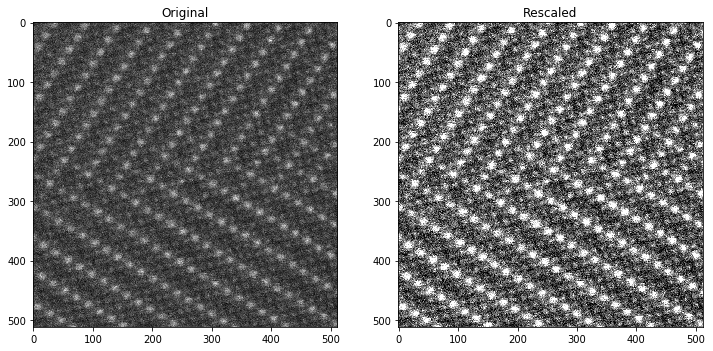

In [108]:
p2, p98 = np.percentile(stem_image, (2, 95))
img_rescale = exposure.rescale_intensity(stem_image, in_range=(p2, p98))

fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
for axis, img, title in zip(axes, [stem_image, img_rescale], ['Original', 'Rescaled']):
    axis.imshow(img, cmap='gray')
    axis.set_title(title)

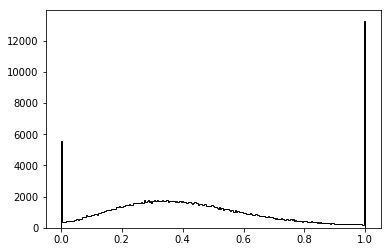

In [109]:
fig, axis = plt.subplots()
axis.hist(img_rescale.ravel(), bins=256, histtype='step', color='black');

### Adaptive adjustment

//anaconda/lib/python3.5/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


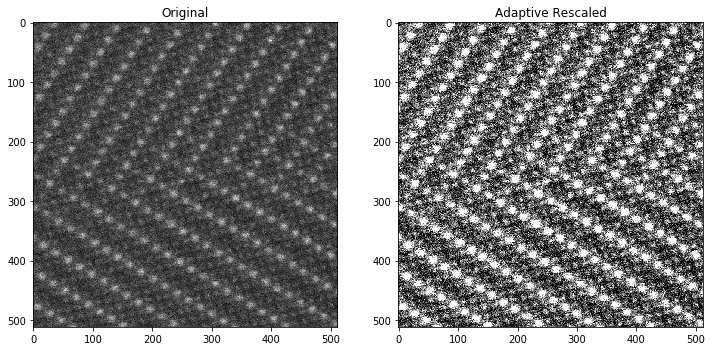

In [106]:

img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
for axis, img, title in zip(axes, [stem_image, img_rescale], ['Original', 'Adaptive Rescaled']):
    axis.imshow(img, cmap='gray')
    axis.set_title(title)

## Frequency space
A lot of information cam be gained by visualizing the same image in the frequency domain:

Text(0.5,1,'FFT2 of image')

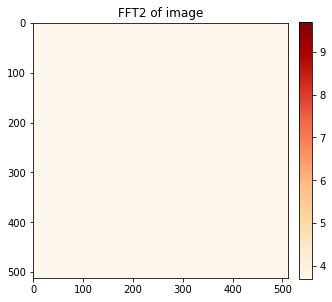

In [31]:
fft_image_raw = np.fft.fft2(stem_image)

fig, axis = plt.subplots(figsize=(5, 5))
# Visualize the magnitude only:
im_hande = axis.imshow(np.abs(fft_image_raw), cmap=plt.cm.OrRd)
# Add a colorbar
cbar = plt.colorbar(im_handle, ax=axis, fraction=0.046, pad=0.04)
axis.set_title('FFT2 of image')

Not much is visible just by taking the 2D FFT. Let's try looking at the log of the FFT:

Text(0.5,1,'FFT2 of image')

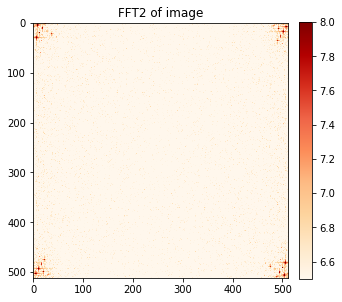

In [38]:
fig, axis = plt.subplots(figsize=(5, 5))
im_handle = axis.imshow(np.log10(np.abs(fft_image_raw)), cmap=plt.cm.OrRd, vmin=[6.5, 8])
# Add a colorbar
cbar = plt.colorbar(im_handle, ax=axis, fraction=0.046, pad=0.04)
axis.set_title('FFT2 of image')

Plotting the magnitude 2D-FFT on a vertical log scales shows something unexpected: there appears to be peaks at the corners and no information at the center. This is because the output for the ``fft2`` function flips the frequency axes so that low frequencies are at the ends, and the highest frequency is in the middle.

#### Correcting the FFT

To correct this, use the ``fftshift`` command. fftshift brings the lowest frequency components of the FFT back to the center of the plot

Text(0.5,1,'FFT after fftshift-ing')

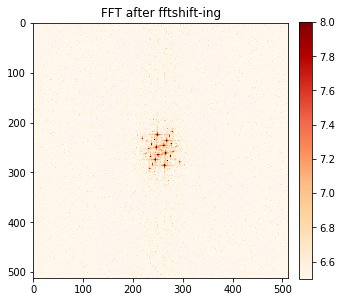

In [37]:
fft_image_raw_shifted = np.fft.fftshift(fft_image_raw)

fig, axis = plt.subplots(figsize=(5, 5))
im_handle = axis.imshow(np.log10(np.abs(fft_image_raw_shifted)), cmap=plt.cm.OrRd, vmin=[6.5, 8])
# Add a colorbar
cbar = plt.colorbar(im_handle, ax=axis, fraction=0.046, pad=0.04)
axis.set_title('FFT after fftshift-ing')

## Image filters
The atomically resolved image above appears to be quite noisy and the atomic columns are not clearly visible. Let's apply some image filters to see what they do to the image:

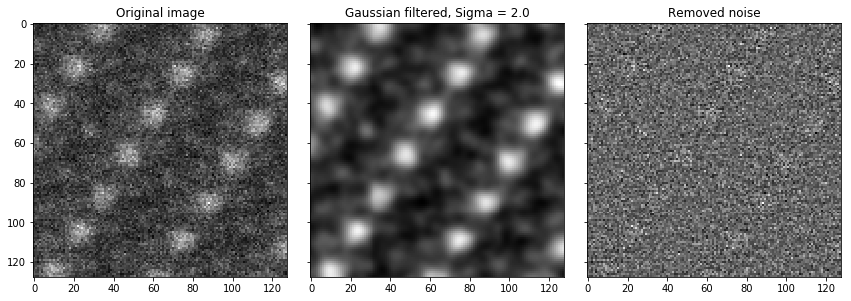

In [250]:

cropped_image = stem_image[:128, :128]

gaus_sigma = 2.0

gaussian_filtered = filters.gaussian(cropped_image, sigma=gaus_sigma)

fig, axes = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)
axes[0].imshow(cropped_image, cmap='gray')
axes[0].set_title('Original image')
axes[1].imshow(gaussian_filtered, cmap='gray')
axes[1].set_title('Gaussian filtered, Sigma = {}'.format(gaus_sigma))
axes[2].imshow(cropped_image - gaussian_filtered, cmap='gray')
axes[2].set_title('Removed noise');
fig.tight_layout()

### Visualize the effect of filtering in the frequency domain:

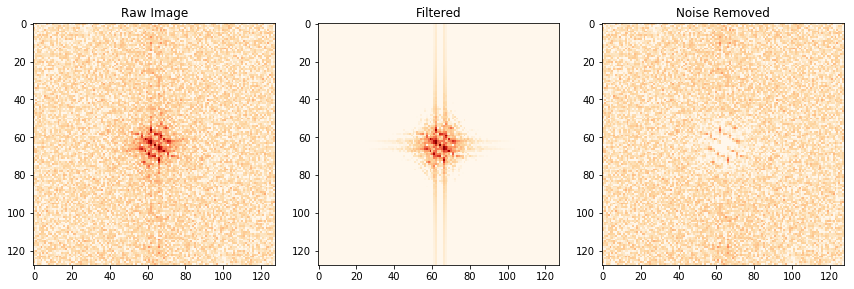

In [274]:
fft_raw = np.fft.fftshift(np.fft.fft2(cropped_image))
fft_noise_rem = np.fft.fftshift(np.fft.fft2(cropped_image - gaussian_filtered))
fft_gaus_filt = np.fft.fftshift(np.fft.fft2(gaussian_filtered))

fig, axes = plt.subplots(ncols=3, figsize=(12, 4))
for axis, fft_img, title in zip(axes.flat, 
                                [fft_raw, fft_gaus_filt, fft_noise_rem],
                                ['Raw Image', 'Filtered', 'Noise Removed']):
    axis.imshow(np.log10(np.abs(fft_img)), cmap=plt.cm.OrRd, vmin=[0.5, 2.5])
    axis.set_title(title)
fig.tight_layout()

## Trying different filter parameters:
In the case of the gaussian filter, one can try differetn values of the standard deviation for the Gaussian kernel via the ``sigma`` keyword argument. 

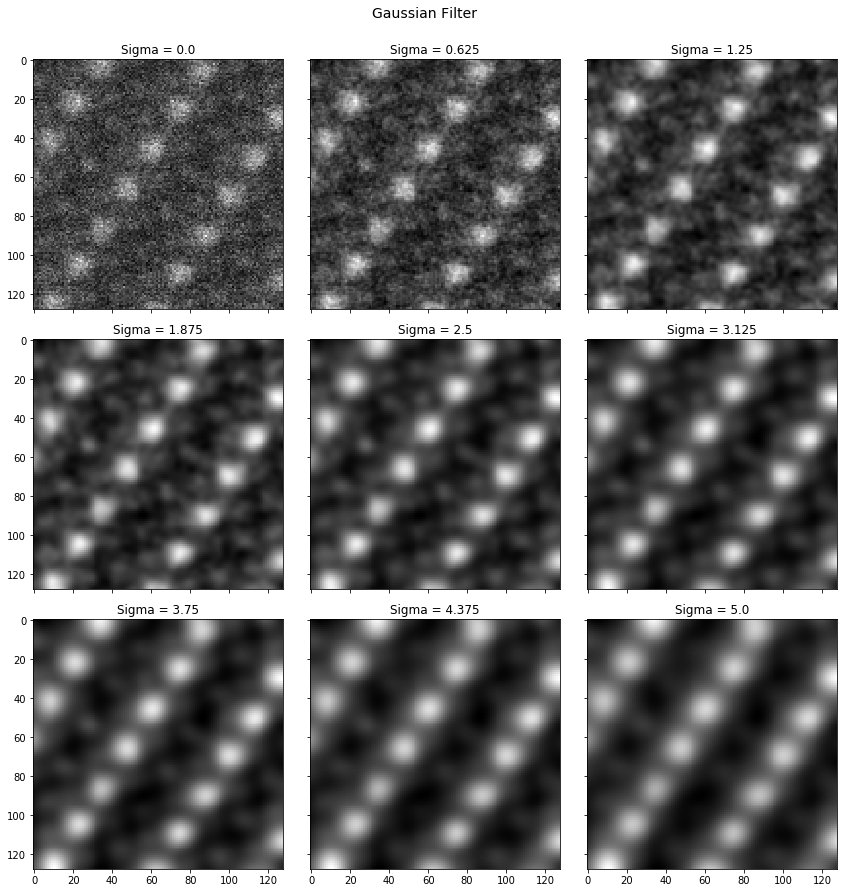

In [244]:
cropped_image = stem_image[:128, :128]

sigma_values = np.linspace(0, 5, num=9)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12), sharex=True, sharey=True)
for axis, gaus_sigma in zip(axes.flat, sigma_values):
    gaussian_filtered = filters.gaussian(cropped_image, sigma=gaus_sigma)
    axis.imshow(gaussian_filtered, cmap='gray')
    axis.set_title('Sigma = {}'.format(gaus_sigma));
fig.suptitle('Gaussian Filter', fontsize=14, y=1.03)
fig.tight_layout()

## More filters:
Several more filters are available in skimage. We will only try out a handful below:
* [Local mean](http://scikit-image.org/docs/dev/auto_examples/xx_applications/plot_rank_filters.html)
* [Median](http://scikit-image.org/docs/dev/auto_examples/xx_applications/plot_rank_filters.html)
* [Gaussian](https://www.scipy-lectures.org/packages/scikit-image/#mathematical-morphology)
* [Unsupervised Wiener](http://scikit-image.org/docs/dev/auto_examples/filters/plot_restoration.html)
* [Bi-lateral Mean](http://scikit-image.org/docs/dev/auto_examples/xx_applications/plot_rank_filters.html)
* [Wiener deconvolution](http://scikit-image.org/docs/dev/api/skimage.restoration.html#skimage.restoration.wiener)

As mentioned above, most filters require manipulation of filter parameters. See if you can improve the filters below:

//anaconda/lib/python3.5/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
//anaconda/lib/python3.5/site-packages/skimage/restoration/uft.py:447: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  impr[([slice(1, 2)] * ndim)] = 2.0 * ndim


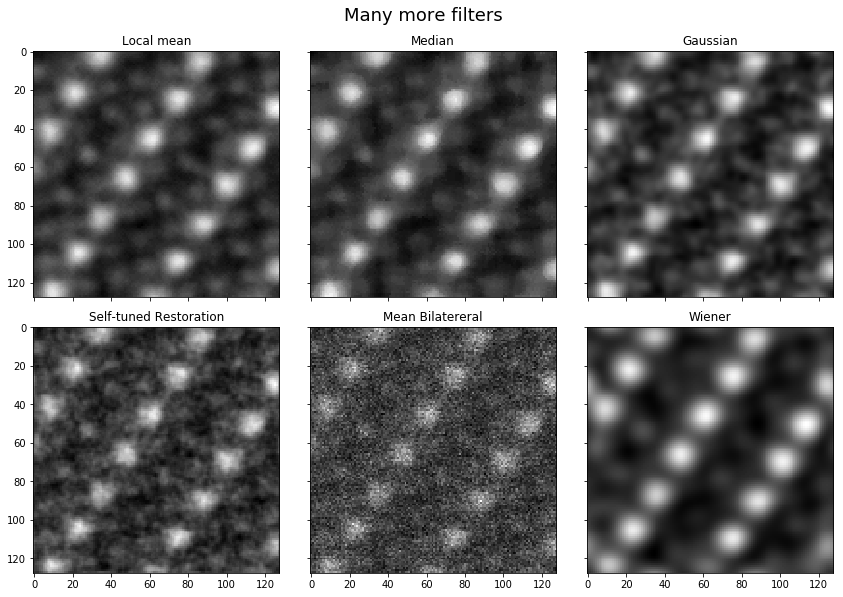

In [278]:
cropped_image = stem_image[:128, :128]

# Local mean filter
loc_mean = filters.rank.mean(cropped_image, disk(4))

# Median filter:
median_filtered = filters.median(cropped_image, disk(5))

# Gaussian Filter
gaussian_filtered = filters.gaussian(cropped_image, sigma=1.875)

# Bilateral mean
noisy_image = skimage.img_as_ubyte(cropped_image)
bilat_filtered = filters.rank.mean_bilateral(noisy_image.astype(np.uint16), disk(10), s0=5, s1=5)

# Self-tuned Wiener
disk_size = int(1)
psf = np.ones((disk_size, disk_size)) / disk_size**2
self_tuned, _ = skimage.restoration.unsupervised_wiener(cropped_image, psf)

# Wiener deconvolution
disk_size = int(10)
psf = np.ones((disk_size, disk_size)) / disk_size**2
wiener_filtered = skimage.restoration.wiener(cropped_image, psf, 50)

# Visualizing results here:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12, 8),
                         sharex=True, sharey=True)
for axis, img, title in zip(axes.flat, 
                            [loc_mean, median_filtered, gaussian_filtered, 
                             self_tuned, bilat_filtered, wiener_filtered],
                            ['Local mean', 'Median', 'Gaussian', 
                             'Self-tuned Restoration', 'Mean Bilatereral', 'Wiener']):
    axis.imshow(img, cmap='gray')
    axis.set_title(title)
fig.suptitle('Many more filters', fontsize=18, y=1.03)
fig.tight_layout()

### Edge filters:

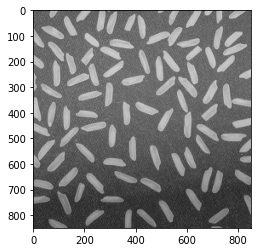

In [246]:
rice_image = io.imread('https://www.mathworks.com/content/mathworks/www/en/company/newsletters/articles/new-features-for-high-performance-image-processing-in-matlab/jcr:content/mainParsys/image_1.adapt.full.high.jpg/1469941471626.jpg')

# Convert to float: Important for subtraction later which won't work with uint8
rice_image = skimage.img_as_float(rice_image)

fig, axis = plt.subplots()
axis.imshow(rice_image, cmap='gray');

In [ ]:
from skimage.morphology import disk

cropped_image = stem_image[:128, :128]

from skimage.filters.rank import mean
loc_mean = mean(cropped_image, disk(4))

median_filtered = filters.median(cropped_image, disk(5))

gaussian_filtered = filters.gaussian(cropped_image, sigma=1.875)

from skimage import restoration
tv_filtered = restoration.denoise_tv_chambolle(cropped_image, weight=0.1)

from skimage.filters.rank import mean_bilateral
noisy_image = skimage.img_as_ubyte(cropped_image)
bilat_filtered = mean_bilateral(noisy_image.astype(np.uint16), disk(10), s0=5, s1=5)

disk_size = int(5)
psf = np.ones((disk_size, disk_size)) / disk_size**2
deconvolved_rl = restoration.richardson_lucy(cropped_image, psf, iterations=30)

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12, 8),
                         sharex=True, sharey=True)
for axis, img, title in zip(axes.flat, 
                            [loc_mean, median_filtered, gaussian_filtered, 
                             tv_filtered, bilat_filtered, deconvolved_rl],
                            ['Local mean', 'Median', 'Gaussian', 
                             'TV Chambolle', 'Mean Bilatereral', 'Richardson-Lucy deconvolution']):
    axis.imshow(img, cmap='gray')
    axis.set_title(title)
fig.suptitle('Many more filters', fontsize=18, y=1.03)
fig.tight_layout()

## [Thresholding](http://scikit-image.org/docs/dev/auto_examples/xx_applications/plot_thresholding.html):

## [Background subtraction](https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_regional_maxima.html):
Quite often, images tend to have some long-range features that make it challenging to perform local operations. Here we will try to remove the background image

//anaconda/lib/python3.5/site-packages/skimage/morphology/greyreconstruct.py:143: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  selem[[slice(d, d + 1) for d in offset]] = False
//anaconda/lib/python3.5/site-packages/skimage/morphology/greyreconstruct.py:161: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  images[[0] + inside_slices] = seed
//anaconda/lib/python3.5/site-packages/skimage/morphology/greyreconstruct.py:162: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `a

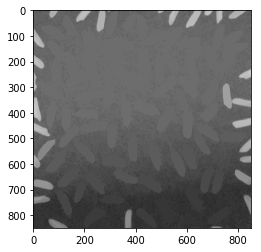

In [129]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter
from skimage import data
from skimage import img_as_float
from skimage.morphology import reconstruction

# Convert to float: Important for subtraction later which won't work with uint8
image = img_as_float(rice_image)
image = gaussian_filter(image, 1)

seed = np.copy(image)
seed[1:-1, 1:-1] = image.min()
mask = image

dilated = reconstruction(seed, mask, method='dilation')
plt.imshow(dilated)

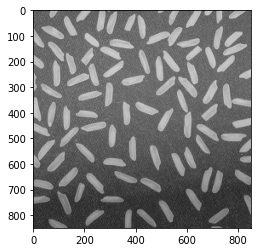

In [120]:
rice_image = io.imread('https://www.mathworks.com/content/mathworks/www/en/company/newsletters/articles/new-features-for-high-performance-image-processing-in-matlab/jcr:content/mainParsys/image_1.adapt.full.high.jpg/1469941471626.jpg')

# Convert to float: Important for subtraction later which won't work with uint8
rice_image = skimage.img_as_float(rice_image)

fig, axis = plt.subplots()
axis.imshow(rice_image, cmap='gray');

//anaconda/lib/python3.5/site-packages/skimage/filters/_gaussian.py:108: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


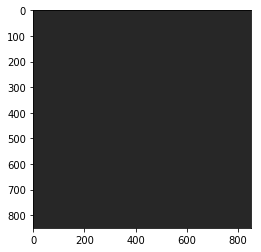

In [126]:
rice_image = filters.gaussian(rice_image, sigma=1)

seed = np.copy(rice_image)
seed[1:-1, 1:-1] = rice_image.min()

#seed = rice_image.min() * np.ones(shape=rice_image.shape)

fig, axis = plt.subplots()
axis.imshow(seed, cmap='gray');

//anaconda/lib/python3.5/site-packages/skimage/morphology/greyreconstruct.py:143: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  selem[[slice(d, d + 1) for d in offset]] = False
//anaconda/lib/python3.5/site-packages/skimage/morphology/greyreconstruct.py:161: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  images[[0] + inside_slices] = seed
//anaconda/lib/python3.5/site-packages/skimage/morphology/greyreconstruct.py:162: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `a

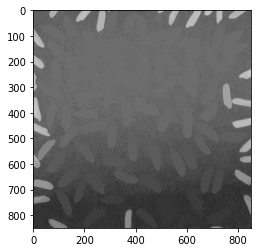

In [127]:
from skimage.morphology import reconstruction

plt.imshow(reconstruction(seed, rice_image, method='dilation'))

## [Blob detection](http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_blob.html) for finding atoms:

Three popular techniques:
* Laplacian of Gaussian (LoG)
* Difference of Gaussian (DoG)
* Determinant of Hessian (DoH)

### Laplacian of Gaussian (LoG)
This is the most accurate and slowest approach. It computes the Laplacian of Gaussian images with successively increasing standard deviation and stacks them up in a cube. Blobs are local maximas in this cube. Detecting larger blobs is especially slower because of larger kernel sizes during convolution. Only bright blobs on dark backgrounds are detected. See skimage.feature.blob_log() for usage.

In [198]:
# Filtering the image slightly before attempting to find atoms
gaussian_filtered = filters.gaussian(stem_image[:128,  :128], sigma=1.875)

result = blob_log(gaussian_filtered, max_sigma=5, num_sigma=10, threshold=0.01)

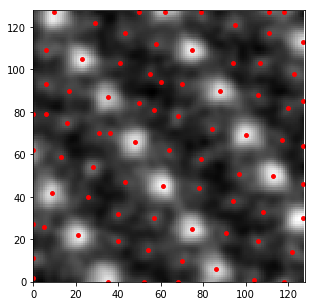

In [207]:
fig, axis = plt.subplots(figsize=(5, 5))
axis.imshow(gaussian_filtered, cmap='gray')
axis.scatter(result[:, 1], result[:, 0], s=15, c='r')
axis.set_xlim(left=0, right=gaussian_filtered.shape[0])
axis.set_ylim(bottom=0, top=gaussian_filtered.shape[1]);

## [Thresholding](http://scikit-image.org/docs/dev/auto_examples/xx_applications/plot_thresholding.html)

//anaconda/lib/python3.5/site-packages/skimage/filters/thresholding.py:221: skimage_deprecation: Function ``threshold_adaptive`` is deprecated and will be removed in version 0.15. Use ``threshold_local`` instead.
  def threshold_adaptive(image, block_size, method='gaussian', offset=0,
//anaconda/lib/python3.5/site-packages/skimage/filters/thresholding.py:223: UserWarning: The return value of `threshold_local` is a threshold image, while `threshold_adaptive` returned the *thresholded* image.
  warn('The return value of `threshold_local` is a threshold image, while '


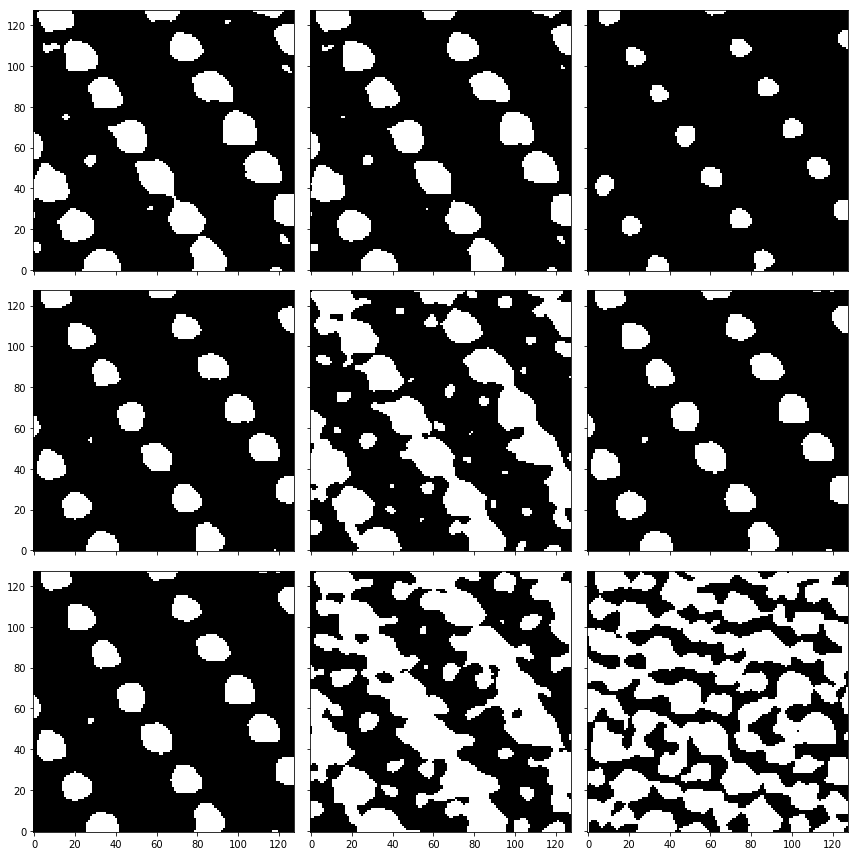

In [208]:
from skimage.filters import threshold_mean, threshold_adaptive, threshold_isodata, threshold_local, threshold_minimum, threshold_otsu, threshold_yen, threshold_triangle, threshold_li


gaussian_filtered = filters.gaussian(stem_image[:128,  :128], sigma=1.875)

# Normalizing to [0, 255]
gaussian_filtered = gaussian_filtered - gaussian_filtered.min()
gaussian_filtered = 255 * gaussian_filtered / gaussian_filtered.max()

thresh = threshold_triangle(gaussian_filtered, nbins=1024)
binary_triangle = gaussian_filtered > thresh

thresh = threshold_li(gaussian_filtered)
binary_li = gaussian_filtered > thresh

thresh = threshold_minimum(gaussian_filtered)
binary_minimum = gaussian_filtered > thresh

thresh = threshold_yen(gaussian_filtered)
binary_yen = gaussian_filtered > thresh

thresh = threshold_mean(gaussian_filtered)
binary_mean = gaussian_filtered > thresh

thresh = threshold_isodata(gaussian_filtered)
binary_isodata = gaussian_filtered > thresh

# Global thresholding
global_thresh = threshold_otsu(gaussian_filtered)
binary_global = gaussian_filtered > global_thresh

# Local thresholding
block_size = 105
local_thresh = threshold_local(gaussian_filtered, block_size, offset=10)
binary_local = gaussian_filtered > local_thresh

# Adaptive thresholding
block_size = 35
binary_adaptive = threshold_adaptive(gaussian_filtered, block_size, offset=10)

fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(12, 12), sharex=True, sharey=True)

for axis, img in zip(axes.flat, [binary_triangle, binary_li, binary_minimum, binary_yen, binary_mean,
                                 binary_isodata, binary_global, binary_local, binary_adaptive]):
    axis.imshow(img, cmap='gray', origin='lower')
fig.tight_layout()

In [57]:
image.max(), image.min(), image.mean()

(255, 0, 118.31400299072266)

In [60]:
gaussian_filtered.max(), gaussian_filtered.min(), gaussian_filtered.mean()

(255, 0, 0.000972747802734375)

* https://www.scipy-lectures.org/packages/scikit-image/
* Registration + alignment
* Segmentation
    * Watershed especially (http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_watershed.html)
    
    https://www.scipy-lectures.org/packages/scikit-image/#feature-extraction-for-computer-vision
    
    https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_regional_maxima.html#sphx-glr-auto-examples-color-exposure-plot-regional-maxima-py
    
    http://members.cbio.mines-paristech.fr/~nvaroquaux/formations/scipy-lecture-notes/advanced/image_processing/index.html
    
    https://www.practicepython.org/blog/2016/12/20/instagram-filters-python.html